# QC, analysis of Gutenkunst three pop out of Africa
Here, we would like to do a sanity check that our models are producing similar results to that found 
in Gutenkunst 2009.  https://doi.org/10.1371/journal.pgen.1000695


In [1]:
import msprime
from stdpopsim import homo_sapiens
import allel
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from allel.util import asarray_ndim, check_integer_dtype

In [3]:
ch = "chr22"
chrom = homo_sapiens.genome.chromosomes[ch]
model = homo_sapiens.GutenkunstThreePopOutOfAfrica()

pops = ["YRI","CEU","CHB"]
treeSequencePath = "./HomoSapians3pop_"+ch+"_50samplesEach.trees"

The tree sequence for this simulation exists at the path 'treeSequencePath',
there is no need to re-simulate if it still exists.
The simulation only takes about a minute for a single chromosome.

In [5]:
# 50 samples each from YRI, CEU and CHB.
samples = [msprime.Sample(population=j, time=0) for j in range(3) for _ in range(50)]

ts = msprime.simulate(
    samples=samples,
    recombination_map=chrom.recombination_map(),
    mutation_rate=chrom.mean_mutation_rate,
    **model.asdict())
ts.dump(treeSequencePath)

First, lets take a look at comparisons to nucleotide diversity within all three populations.

In [4]:
ts = msprime.load(treeSequencePath)
gm = ts.genotype_matrix()

#make a haplotype data struct out of each population gentype matrices
haplotype_arrays = [allel.HaplotypeArray(gm[:,ts.samples(population=i)]) for i in range(3)]
total_haplo = allel.HaplotypeArray(gm)

#counts all ancestral/derived alleles at each site
allele_counts = [pop.count_alleles() for pop in haplotype_arrays]
total_ac = total_haplo.count_alleles()

#positions of all SNPs
pos = np.array([s.position for s in ts.sites()],dtype='float32')

for i,ac in enumerate(allele_counts):
    nd = allel.sequence_diversity(pos=pos,ac=ac)
    print("pop %s nucleotide diversity = " %(pops[i]),nd)
    
td = allel.sequence_diversity(pos=pos,ac=total_ac)
print("\ntotal nucleotide diversity: ",td)

pop YRI nucleotide diversity =  0.0003574865134137377
pop CEU nucleotide diversity =  0.00024608410648264305
pop CHB nucleotide diversity =  0.00022984313012308603

total nucleotide diversity:  0.00030581216106256295


Next, Lets look at the joint site frequency spectrum between all populations

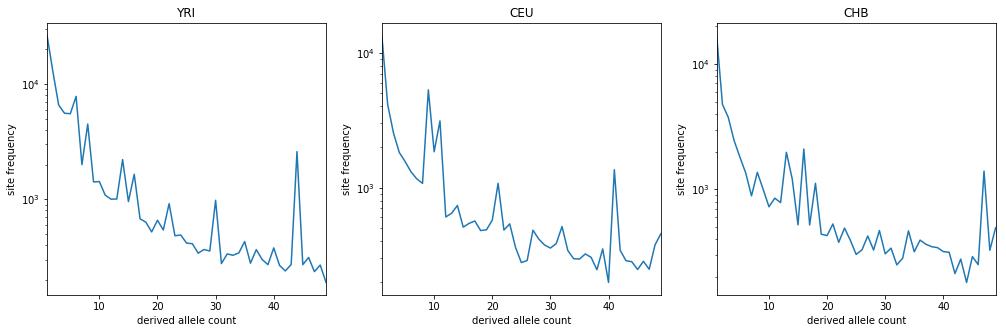

In [6]:
#Get derived counts from allele counts
dc = [ac[:,1] for ac in allele_counts]

fig0,ax0 = plt.subplots(1,3)
for i in range(3):
    fs = allel.sfs(dc[i])
    allel.plot_sfs(fs,ax=ax0[i])
    ax0[i].set_title(pops[i])
    
fig0.set_size_inches(17.0,5.0)
plt.show()

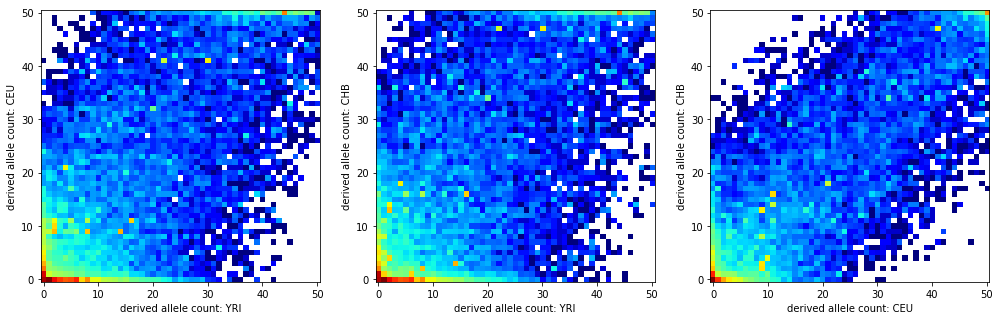

In [10]:
#compute joint site frequency spectrum between all combinations of populations
combs = [[0,1],[0,2],[1,2]]
joint_sfs = np.array([allel.joint_sfs(dc[comb[0]],dc[comb[1]]) for comb in combs])

fig1,ax1 = plt.subplots(1,3)
for i in range(3):
    x = allel.plot_joint_sfs(joint_sfs[i],ax=ax1[i])
    ax1[i].set_xlabel("derived allele count: %s"%(pops[combs[i][0]]))
    ax1[i].set_ylabel("derived allele count: %s"%(pops[combs[i][1]]))
    
fig1.set_size_inches(17.0,5.0)
plt.show()


## Figure 2 from Gutenkunst 2009

![title](./journal.pgen.1000695.g002.png)